In [1]:
import numpy as np
%matplotlib inline

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


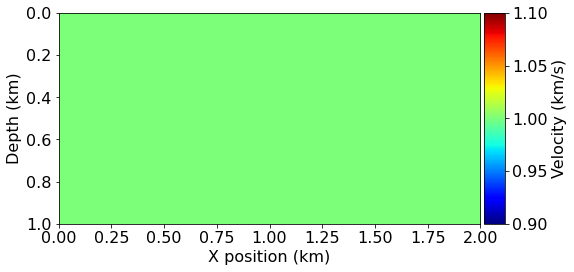

(2000.0, 1000.0)


In [2]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import *

# Define a physical size
shape = (201, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:,:] = 1

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=10, bcs="damp")

plot_velocity(model)
print(model.domain_size)

In [3]:
from examples.seismic import TimeAxis

t0 = 0.  # Simulation starts a t=0
tn = 750.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing
time_range = TimeAxis(start=t0, stop=tn, step=dt)


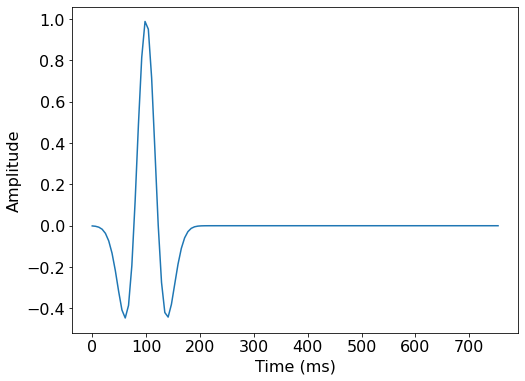

In [4]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import RickerSource

f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

# Set source coordinates
src.coordinates.data[0, 0] =model.domain_size[0] * .5
src.coordinates.data[0, 1] =model.domain_size[1] * .5

# We can plot the time signature to see the wavelet via:
src.show()

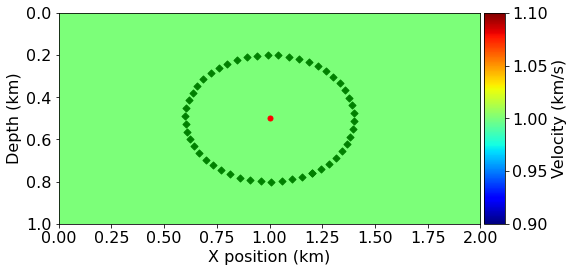

In [5]:
#NBVAL_IGNORE_OUTPUT

from examples.seismic import Receiver
from numpy import *
# Create symbol for 101 receivers
n_rec=201
rec = Receiver(name='rec', grid=model.grid, npoint=n_rec, time_range=time_range)
#rec.coordinates.data[:,0]=np.linspace(0,model.domain_size[0],200)
m0=model.domain_size[0]/2
m1=model.domain_size[1]/2
a,b=0.4*m0,0.6*m1
x=0
while (x<201):
    rec.coordinates.data[x,0]=a*cos(x*2*pi/200+pi/3)+m0
    rec.coordinates.data[x,1]=b*sin(x*2*pi/200+pi/3)+m1
    x+=1
    
plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4])

In [6]:
# In order to represent the wavefield u and the square slowness we need symbolic objects 
# corresponding to time-space-varying field (u, TimeFunction) and 
# space-varying field (m, Function)
from devito import TimeFunction

# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)

# We can now write the PDE
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

# The PDE representation is as on paper
pde


damp(x, y)*Derivative(u(t, x, y), t) - Derivative(u(t, x, y), (x, 2)) - Derivative(u(t, x, y), (y, 2)) + Derivative(u(t, x, y), (t, 2))/vp(x, y)**2

In [8]:
# This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as 
# a time marching updating equation known as a stencil using customized SymPy functions
from devito import Eq, solve

stencil = Eq(u.forward, solve(pde, u.forward))

In [9]:
# Finally we define the source injection and receiver read function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u.forward)


In [10]:
#NBVAL_IGNORE_OUTPUT
from devito import Operator

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)


Now we can execute the create operator for a number of timesteps. We specify the number of timesteps to compute with the keyword `time` and the timestep size with `dt`.

In [11]:
#NBVAL_IGNORE_OUTPUT
op(time=time_range.num-1, dt=model.critical_dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.001901999999999996, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=4e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.0002869999999999997, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

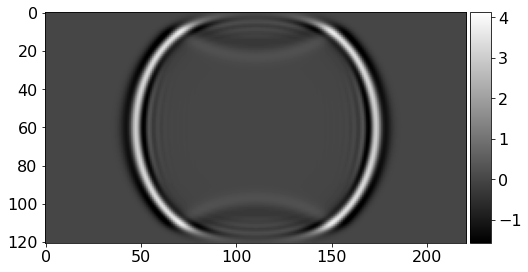

In [12]:
plot_image(u.data[0])

After running our operator kernel, the data associated with the receiver symbol `rec.data` has now been populated due to the interpolation expression we inserted into the operator. This allows us the visualize the shot record:

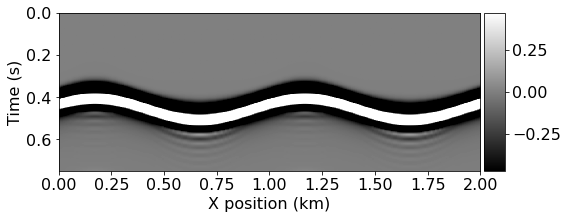

In [13]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

plot_shotrecord(rec.data, model, t0, tn)

In [22]:
n_events=1
t_rec=np.zeros(shape=(n_rec,n_events))
for i in range(0,n_rec):
    # n_events is not known
    for j in range(0,int(tn/dt)-2):
        if( (rec.data[j,i]==0 )and (rec.data[j+1,i]!=0 )and (rec.data[j+2,i] !=0)):
            t_rec[i]=j*dt
            x+=1
            
            

In [23]:
print(t_rec)

[[275.58000326]
 [269.45600319]
 [263.33200312]
 [263.33200312]
 [257.20800304]
 [257.20800304]
 [251.08400297]
 [238.83600283]
 [232.71200275]
 [232.71200275]
 [226.58800268]
 [220.46400261]
 [208.21600246]
 [202.09200239]
 [195.96800232]
 [189.84400225]
 [177.5960021 ]
 [177.5960021 ]
 [183.72000217]
 [189.84400225]
 [202.09200239]
 [208.21600246]
 [214.34000254]
 [220.46400261]
 [232.71200275]
 [232.71200275]
 [238.83600283]
 [244.9600029 ]
 [251.08400297]
 [257.20800304]
 [263.33200312]
 [269.45600319]
 [269.45600319]
 [275.58000326]
 [275.58000326]
 [281.70400333]
 [281.70400333]
 [287.82800341]
 [287.82800341]
 [287.82800341]
 [293.95200348]
 [293.95200348]
 [293.95200348]
 [300.07600355]
 [300.07600355]
 [300.07600355]
 [300.07600355]
 [300.07600355]
 [300.07600355]
 [293.95200348]
 [300.07600355]
 [300.07600355]
 [293.95200348]
 [293.95200348]
 [287.82800341]
 [287.82800341]
 [281.70400333]
 [281.70400333]
 [281.70400333]
 [275.58000326]
 [275.58000326]
 [269.45600319]
 [263.33

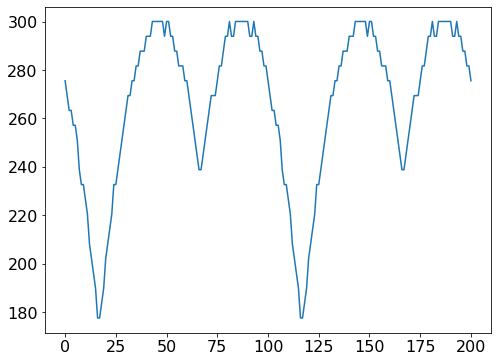

In [29]:
import  matplotlib.pyplot as plt
time_axis=np.linspace(start=0,stop=tn,num=int(tn/dt))
plt.plot(t_rec, )